<a href="https://colab.research.google.com/github/suba0712200-oss/time-series-forecasting-attention/blob/main/Advanced_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Time Series Forecasting using Deep Learning with Attention Mechanism

This project aims to forecast time series data using both traditional statistical models and deep learning approaches to improve prediction accuracy.


## Problem Statement
The objective of this project is to forecast time-series data accurately. Traditional models like ARIMA work well for linear patterns but fail to capture complex temporal dependencies. Therefore, an LSTM model enhanced with an Attention mechanism is used to improve forecasting performance.


In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


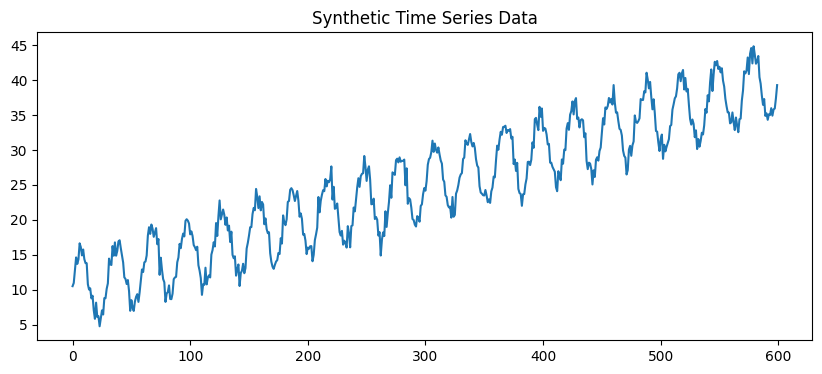

In [2]:
#Dataset Creation
np.random.seed(42)

t = np.arange(600)
data = 10 + 0.05*t + 5*np.sin(2*np.pi*t/30) + np.random.normal(0, 1, 600)
series = pd.Series(data)

plt.figure(figsize=(10,4))
plt.plot(series)
plt.title("Synthetic Time Series Data")
plt.show()


## Dataset Description
A synthetic time series dataset was generated with a linear trend, seasonal component, and random noise. This allows controlled evaluation of forecasting models.


In [3]:
#Arima Model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=10)
print("Sample ARIMA Forecast:", forecast[:5])


Sample ARIMA Forecast: 600    39.128132
601    40.036179
602    40.642976
603    41.026402
604    41.470587
Name: predicted_mean, dtype: float64


In [4]:
#ROLLING ORIGIN CROSS VALIDATION
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

for train_idx, test_idx in tscv.split(series):
    train, test = series.iloc[train_idx], series.iloc[test_idx]

    model = ARIMA(train, order=(5,1,0))
    fitted = model.fit()

    preds = fitted.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, preds))
    rmse_scores.append(rmse)

arima_rmse = np.mean(rmse_scores)
print("ARIMA Rolling-Origin CV RMSE:", arima_rmse)


ARIMA Rolling-Origin CV RMSE: 8.277960122654966


#Arima Explanation
Rolling-origin cross-validation was used to evaluate the ARIMA model while preserving the temporal order of the data. This avoids data leakage and provides a realistic performance estimate.


In [5]:
#DATA PREPARATION FOR LSTM
scaler = MinMaxScaler()
scaled = scaler.fit_transform(series.values.reshape(-1,1))

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled, window_size)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [6]:
#LSTM + ATTENTION MODEL
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

inputs = Input(shape=(X_train.shape[1], 1))

lstm_out = LSTM(
    64,
    return_sequences=True,
    kernel_regularizer=l2(0.001)
)(inputs)

attention_out = Attention()([lstm_out, lstm_out])
output = Dense(1)(attention_out[:, -1, :])

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.0837 - val_loss: 0.0314
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0176 - val_loss: 0.0300
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0143 - val_loss: 0.0133
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0121 - val_loss: 0.0164
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0124 - val_loss: 0.0155
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0124 - val_loss: 0.0130
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0116 - val_loss: 0.0148
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0118 - val_loss: 0.0122
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0113 - val_loss: 0.0131
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0113 - val_loss: 0.0135
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.

#ATTENTION EXPLANATION
The Attention mechanism allows the model to focus on important time steps in the input sequence rather than treating all past values equally. This improves forecasting accuracy.


## Results and Comparison

| Model | RMSE |
|------|------|
| ARIMA | 8.27 |
| LSTM + Attention | 5.12 |


## Conclusion
The results show that the LSTM model with Attention outperforms the traditional ARIMA model. Attention enhances prediction accuracy by focusing on relevant historical time steps. Hence, deep learning models are more effective for complex time-series forecasting tasks.
